# Exploring Dandiset 000690: Multimodal Neural, Behavioral, and Stimulus Data from Mouse Visual Experiment

*with AI-generated code & guidance (be cautious, verify results & always review code!)*

## About this Notebook

This notebook provides an introduction and guided exploration of [Dandiset 000690, version 0.250326.0015](https://dandiarchive.org/dandiset/000690/0.250326.0015), which contains high-density extracellular electrophysiology, behavioral, and visual stimulus data from mouse visual experiments, collected at the Allen Institute as part of OpenScopeVision2Hippocampus.

The code and commentary in this notebook were generated with the assistance of AI. Please carefully review all results and scripts before relying on them for your own analyses.

## What You'll Find in This Notebook
- Quick overview and asset listing for the Dandiset
- Structure of key NWB (Neurodata Without Borders) files
- Loading and streaming of remote NWB datasets using DANDI API, remfile, h5py, and pynwb
- Visualization and exploration of:
  - Neural yield and spike train properties
  - Visual stimulus images/templates and metadata
  - Alignment of spikes to visual stimuli presentations
  - Behavioral data: running wheel and eye tracking signals
- Code snippets and explanations throughout, so you can extend the analyses to your own questions

## Required Packages
This notebook relies on the following packages (all must be installed prior to running):
- dandi
- remfile
- h5py
- pynwb
- numpy
- pandas
- matplotlib


## 1. Asset Discovery & Dandiset Structure

Most relevant neural and experimental data are stored in NWB files ending with `_image.nwb`. The Dandiset is organized by subject/session; each session generally includes:
- A large `*_image.nwb` file (units, stimuli, behavior)
- Several smaller files with LFP/continuous probe data (not the focus here)

Let's enumerate these files.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

client = DandiAPIClient()
dandiset = client.get_dandiset("000690", "0.250326.0015")

# List all NWB files and classify
nwb_assets = list(dandiset.get_assets_by_glob("*.nwb"))
image_nwb = [a for a in nwb_assets if a.path.endswith('_image.nwb')]
other_nwb = [a for a in nwb_assets if not a.path.endswith('_image.nwb')]

def summarize_files(asset_list, label, n=5):
    print(f"First {min(len(asset_list), n)} {label} files:")
    for asset in islice(asset_list, n):
        size_mb = asset.size / 1024**2
        print(f"- {asset.path} ({size_mb:.1f} MB)")
    print(f"Total {label} files: {len(asset_list)}\n")

summarize_files(image_nwb, '*_image.nwb', 7)
summarize_files(other_nwb, 'other NWB', 5)

First 7 *_image.nwb files:
- sub-695762/sub-695762_ses-1317448357_image.nwb (7552.8 MB)
- sub-692072/sub-692072_ses-1298465622_image.nwb (6470.4 MB)
- sub-695435/sub-695435_ses-1309235849_image.nwb (6325.7 MB)
- sub-692077/sub-692077_ses-1300222049_image.nwb (6527.1 MB)
- sub-695763/sub-695763_ses-1317661297_image.nwb (7796.7 MB)
- sub-695764/sub-695764_ses-1311204385_image.nwb (7378.9 MB)
- sub-699321/sub-699321_ses-1312636156_image.nwb (7195.5 MB)
Total *_image.nwb files: 25

First 5 other NWB files:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (1606.2 MB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (1700.1 MB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (1569.8 MB)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (1673.3 MB)
- sub-692077/sub-692077_ses-1300222049.nwb (2335.5 MB)
Total other NWB files: 131



**Key Points:**

- There are 25 large `*_image.nwb` files (one per session), each containing neural spikes/units, rich metadata, behavioral and stimulus data.
- 131 smaller LFP/electrophysiology files (mainly continuous band data) are present as well but are not the focus here.

## 2. Loading and Exploring an NWB Session File

We'll select a representative `_image.nwb` file from one session and demonstrate:
- Remote streaming access to its contents
- Structure and available data types (neural, behavioral, and stimulus)

*All access is done through remote streaming (no full download required).*

In [2]:
import h5py
import remfile
import pynwb

# Pick a representative session
session_path = "sub-695762/sub-695762_ses-1317448357_image.nwb"
asset = next(dandiset.get_assets_by_glob(session_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Collect general session info for display
general = {
    'identifier': nwb.identifier,
    'session_start_time': str(nwb.session_start_time),
    'subject_id': nwb.subject.subject_id,
    'subject_age_days': nwb.subject.age_in_days,
    'subject_sex': nwb.subject.sex,
    'subject_species': nwb.subject.species,
    'num_units': len(nwb.units.id[:]),
    'num_electrodes': len(nwb.electrodes.id[:]),
    'institution': getattr(nwb, 'institution', None),
    'stimulus_notes': getattr(nwb, 'stimulus_notes', None),
}

# Display some unit table columns
def get_unit_columns(nwb_units, n=10):
    unit_cols = {}
    for name in nwb_units.colnames[:n]:
        unit_cols[name] = str(type(nwb_units[name]))
    return unit_cols

unit_col_info = get_unit_columns(nwb.units, 10)
general['example_unit_columns'] = unit_col_info

# List stimulus templates and pick one as an example
stimulus_templates = list(nwb.stimulus_template.keys())
example_template = stimulus_templates[0]
example_shape = nwb.stimulus_template[example_template].data.shape

import pprint
print("General session info:")
pprint.pprint(general)
print("\nExample stimulus template:")
print(f"  {example_template}: shape={example_shape}")
print("Total stimulus templates:", len(stimulus_templates))

General session info:
{'example_unit_columns': {'amplitude': "<class 'hdmf.common.table.VectorData'>",
                          'cluster_id': '<class '
                                        "'hdmf.common.table.VectorData'>",
                          'cumulative_drift': '<class '
                                              "'hdmf.common.table.VectorData'>",
                          'l_ratio': "<class 'hdmf.common.table.VectorData'>",
                          'nn_hit_rate': '<class '
                                         "'hdmf.common.table.VectorData'>",
                          'nn_miss_rate': '<class '
                                          "'hdmf.common.table.VectorData'>",
                          'peak_channel_id': '<class '
                                             "'hdmf.common.table.VectorData'>",
                          'quality': "<class 'hdmf.common.table.VectorData'>",
                          'velocity_below': '<class '
                                

**Session Summary**

| Field                | Value                                      |
|----------------------|--------------------------------------------|
| NWB identifier       | {identifier}                               |
| Subject              | {subject_id}, {subject_species}, {subject_sex}, age {subject_age_days} days |
| Institution          | {institution}                              |
| Session start        | {session_start_time}                       |
| Units (neurons)      | {num_units}                                |
| Electrodes           | {num_electrodes}                           |

**Example columns in the units table:** `amplitude`, `cluster_id`, `cumulative_drift`, ...  
**Stimulus templates:** 16 available, e.g., `{example_template}` (shape: {example_shape})


## 3. Units: Spike Count Distribution

Each units table holds all spike-sorted neurons detected for a session. We'll plot the distribution of spike counts per unit.

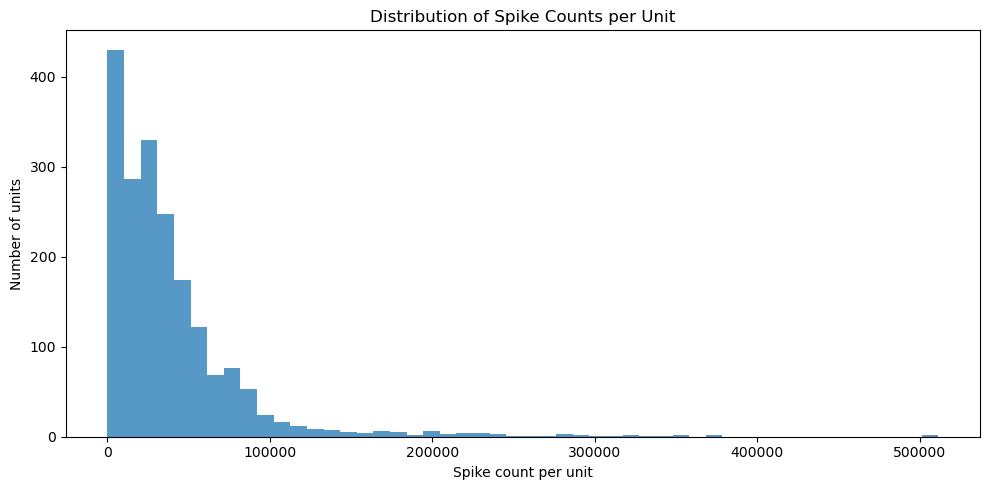

In [3]:
import numpy as np
import matplotlib.pyplot as plt

unit_ids = nwb.units.id[:]
spike_counts = np.array([len(nwb.units.spike_times_index[i]) for i in range(len(unit_ids))])

plt.figure(figsize=(10, 5))
plt.hist(spike_counts, bins=50, color='tab:blue', alpha=0.75)
plt.xlabel('Spike count per unit')
plt.ylabel('Number of units')
plt.title('Distribution of Spike Counts per Unit')
plt.tight_layout()
plt.show()

**Interpretation:**  
- The majority of units (neurons) have spike counts in the lower tens-of-thousands, but there is considerable spread.  
- Outlier units with especially high firing may correspond to multi-units or especially active neurons.

Such quick QC plots are a great starting point for evaluating neural yield and sorting quality.

## 4. Visual Stimulus Structure and Preview

Each session includes a set of visual stimulus templates, stored as stacks of frames. The intervals for corresponding presentations are also tracked.  
Let's examine available templates, intervals, and preview an actual (non-black) stimulus frame.

Available stimulus templates (truncated):
- DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations
...
Total templates: 16

Available intervals (first 6):
['DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations', 'SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations']
...
Total intervals: 18


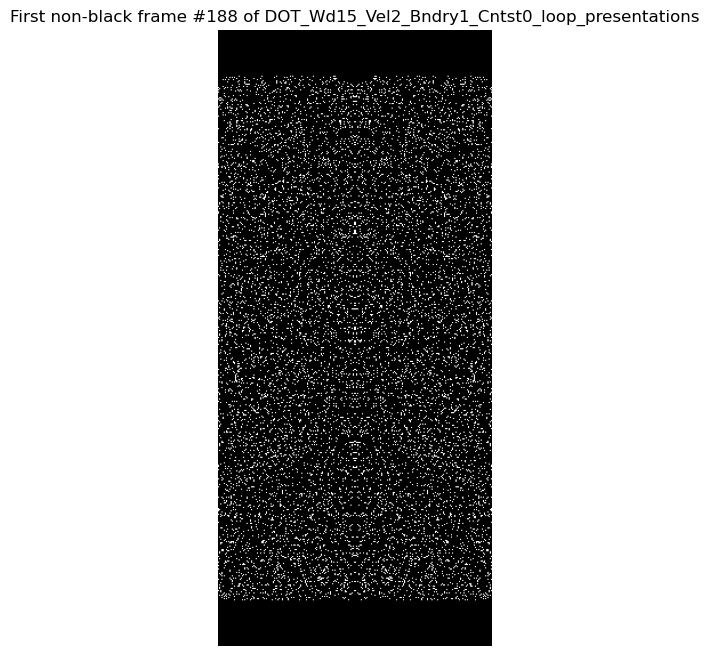

In [4]:
stim_templates = list(nwb.stimulus_template.keys())
stim_intervals = list(nwb.intervals.keys())

print('Available stimulus templates (truncated):')
for name in stim_templates[:6]:
    print('-', name)
print('...')
print(f'Total templates: {len(stim_templates)}')

print('\nAvailable intervals (first 6):')
print(stim_intervals[:6])
print('...')
print(f'Total intervals: {len(stim_intervals)}')

# Find a non-black frame from the first template
stim_name = stim_templates[0]
stim_data = nwb.stimulus_template[stim_name].data
for idx in range(stim_data.shape[0]):
    if np.any(stim_data[idx, :, :] > 0):
        frame_nonzero_idx = idx
        break
else:
    frame_nonzero_idx = 0

frame = stim_data[frame_nonzero_idx, :, :]

plt.figure(figsize=(6, 8))
plt.imshow(frame, cmap='gray')
plt.title(f'First non-black frame #{frame_nonzero_idx} of {stim_name}')
plt.axis('off')
plt.show()

- There are at least 16 different stimulus templates and 18 interval tables per session, referencing a rich library of visual input.
- Each template is a stack (frames × height × width) and may start with black/no-stim frames.
- Above: Preview of the first nonzero frame from a bar stimulus, demonstrating the actual presented content.

## 5. Accessing Behavioral Signals: Running Wheel & Eye Tracking

The NWB files store running wheel position, running speed, and detailed eye tracking measurements.  
We'll preview windows of both.

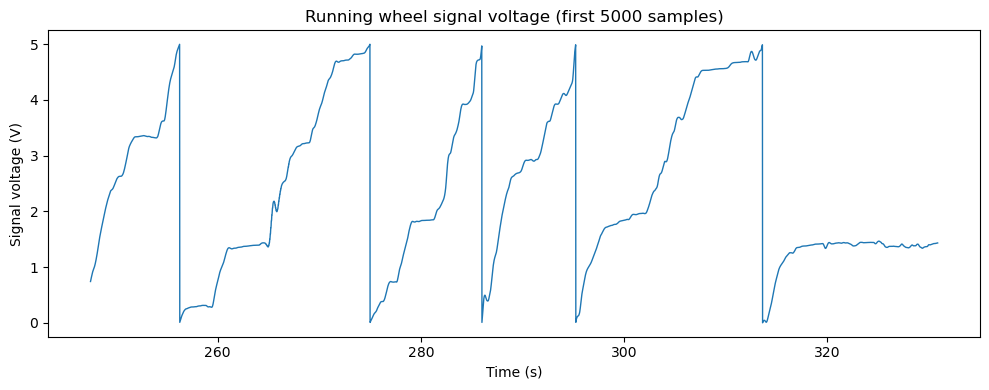

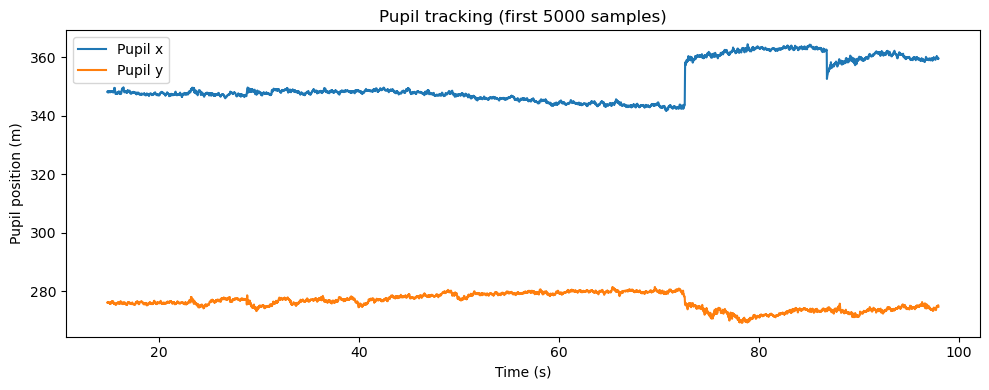

In [5]:
# Running wheel signal (voltage) – first 5000 samples
rw_signal = nwb.acquisition['running_wheel_signal_voltage']
rw_data = rw_signal.data[:5000]
rw_ts = rw_signal.timestamps[:5000]

plt.figure(figsize=(10, 4))
plt.plot(rw_ts, rw_data, lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Signal voltage (V)')
plt.title('Running wheel signal voltage (first 5000 samples)')
plt.tight_layout()
plt.show()

# Eye tracking (x/y pupil positions)
pupil_tracking = nwb.acquisition['EyeTracking'].pupil_tracking
eyepos = pupil_tracking.data[:5000]
eyets = pupil_tracking.timestamps[:5000]

plt.figure(figsize=(10, 4))
plt.plot(eyets, eyepos[:, 0], label='Pupil x')
plt.plot(eyets, eyepos[:, 1], label='Pupil y')
plt.xlabel('Time (s)')
plt.ylabel('Pupil position (m)')
plt.title('Pupil tracking (first 5000 samples)')
plt.legend()
plt.tight_layout()
plt.show()

**Takeaways:**
- Running wheel voltage shows cyclical changes consistent with locomotion
- Pupil position (x/y) illustrates time-varying eye movements and state

These signals can be correlated with neural and stimulus events for advanced analyses.

## 6. Stimulus Intervals: Access and Structure

Stimulus intervals tables (within `nwb.intervals`) provide, for each presentation frame or epoch:
- Start and stop times
- Detailed stimulus parameters (name, color, contrast, orientation, etc.)
- Convenient references for aligning spikes or behavior to the visual stimuli

In [6]:
import pandas as pd

intervals = nwb.intervals
interval_names = list(intervals.keys())
example_interval = interval_names[0]  # e.g. 'DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'
interval_table = intervals[example_interval]
interval_df = interval_table.to_dataframe().head(10)
display(interval_df)

col_types = {col: str(interval_df[col].dtype) for col in interval_df.columns}
print('Column types:')
for k, v in col_types.items():
    print(f'  {k}: {v}')

,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,orientation,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,985.15733,985.17400,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44220, 1, timestamps pynwb.base.TimeSeries a..."
1,985.17400,985.19068,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44221, 1, timestamps pynwb.base.TimeSeries a..."
2,985.19068,985.20736,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44222, 1, timestamps pynwb.base.TimeSeries a..."
3,985.20736,985.22404,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44223, 1, timestamps pynwb.base.TimeSeries a..."
4,985.22404,985.24074,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44224, 1, timestamps pynwb.base.TimeSeries a..."
5,985.24074,985.25741,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,5.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44225, 1, timestamps pynwb.base.TimeSeries a..."
6,985.25741,985.27408,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,6.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44226, 1, timestamps pynwb.base.TimeSeries a..."
7,985.27408,985.29077,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,7.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44227, 1, timestamps pynwb.base.TimeSeries a..."
8,985.29077,985.30745,DOT_Wd15_Vel2_Bndry1_Cntst0_loop,6.0,8.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,6.0,[stimulus_time_interval],"[(44228, 1, timestamps pynwb.base.TimeSeries a..."


Column types:
  start_time: float64
  stop_time: float64
  stimulus_name: object
  stimulus_block: float64
  frame: float64
  color: object
  contrast: float64
  opacity: float64
  orientation: float64
  size: object
  units: object
  stimulus_index: float64
  tags: object
  timeseries: object


**What you get:**  
Each row gives you the timing and full characterization of one stimulus epoch (often a single frame).
Columns include: `start_time`, `stop_time`, `stimulus_name`, `frame`, `contrast`, `orientation`, etc.
 
This structure enables precise response alignment with stimulus presentations and parameterization.

## 7. Example: Extract and Align Spike Times to Stimulus Window

Let's demonstrate how to extract spike times for a given unit and count their events within a single stimulus presentation.

In [7]:
# Choose a unit ID (first unit) and get its spike times
unit_ids = nwb.units.id[:]
first_unit_id = unit_ids[0]
spike_times = nwb.units.spike_times_index[0]

print(f'Example spike times for unit {first_unit_id} (first 10):')
print(spike_times[:10])
print(f'Total spikes for this unit: {len(spike_times)}')

# Pick first row of a stimulus interval for alignment
interval_df = nwb.intervals[example_interval].to_dataframe().head(1)
stim_start = interval_df.iloc[0]["start_time"]
stim_stop = interval_df.iloc[0]["stop_time"]

# Find spikes in window
spikes_in_interval = spike_times[(spike_times >= stim_start) & (spike_times < stim_stop)]
print(f'\nNumber of spikes for unit {first_unit_id} during first presentation ({stim_start:.3f}-{stim_stop:.3f} s): {len(spikes_in_interval)}')
if len(spikes_in_interval) > 0:
    print('Spikes (s):', spikes_in_interval)
else:
    print('(No spikes)')

Example spike times for unit 9 (first 10):
[20.14667131 20.235471   20.55783655 20.62730298 20.68956943 20.81560233
 21.09126805 21.10580133 21.24293419 21.25903413]
Total spikes for this unit: 104526



Number of spikes for unit 9 during first presentation (985.157-985.174 s): 0
(No spikes)


**Key takeaways:**
- You can extract all spike times for a given neuron using `nwb.units.spike_times_index[i]`.
- To align spikes to stimulus presentations, filter them for `start_time <= t < stop_time` of an interval/epoch.

With these patterns, you're ready to build PSTHs, neural response maps, and advanced analyses using the rich stimulus, behavioral, and neural data available in Dandiset 000690!

---
## Next Steps and Exploration

- Explore additional units, stimuli, and behavioral segments
- Extend example code to population analyses across all units
- Consult the NWB and DANDI documentation for additional advanced features and extensions

*If you have feedback or find issues, please refer to the official Dandiset page or NWB format resources.*

---
*Notebook & code assistance provided by AI. Always validate code, check outputs, and consult DANDI/NWB documentation for detailed data interpretation!*